# DCGAN to draw dancers 1
This notebook contains the code of an implementation of a Deep Convolutional Generative Adversarial Network (DCGAN) whose goal is to generate images that remind you of dancers. It is based on https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/DCGAN-face-creation.ipynb.

## Dataset
It consists of images of dancers found on the web. These images do lack consistency...
The resolution is 128 by 128 pixels with 3 bytes for the color dimension.

## Output
The _output_ directory contains animated Gif of generated frame captured during the process of learning.

## Init

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gif
from matplotlib.image import imread
from scipy.misc import imresize, imsave
import tensorflow as tf
%matplotlib inline

In [2]:
data_dir = "./dataset"
tmp_dir = "./tmp"
output_dir = "./output"

filepaths = []
for dir_, _, files in os.walk(data_dir):
    for fileName in files:
        if '.jpg' in fileName:
            filepaths.append(data_dir + "/" + fileName)

if not os.path.isdir(tmp_dir):
    os.makedirs(tmp_dir)

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
    
assert(len(filepaths) > 0)

In [3]:
# randomly pick 'num' images from the dataset
def next_batch(num=10, data=filepaths):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [imread(data[i]) for i in idx]
    return np.asarray(data_shuffle)

In [4]:
allimgs = []  # to save into an animated gif

def save_imgs(imgs, batch_index):
    m = imgs[0]
    allimgs.append(m)
    plt.axis('off')
    plt.imshow(m)
    plt.imsave(fname=tmp_dir + '/img{}.jpg'.format(round(i/10)), arr=m)
    plt.show()

## Definition of the neural network

In [5]:
tf.reset_default_graph()
batch_size = 10
n_noise = 10

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 128, 128, 3], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 128, 128, 3])
        
        x = tf.layers.conv2d(x, kernel_size=5, filters=256, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, kernel_size=5, filters=128, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        
        x = tf.contrib.layers.flatten(x)
        
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x
    
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.9
    with tf.variable_scope("generator", reuse=None):
        x = z
        
        d1 = 5 #3
        d2 = 3
        
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[32, 32])
                
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=256, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)

        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=128, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=3, strides=1, padding='same', activation=tf.nn.sigmoid)
        
        return x    

## Losses and optimizers

In [6]:
g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]

d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))

loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.0002).minimize(loss_g + g_reg, var_list=vars_g)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Training the network

0 3.2237039 0.70444506
not training generator


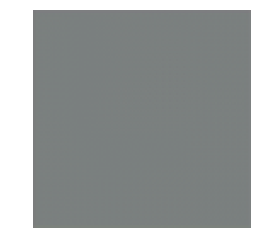

1 1.657342 0.03733198
2 1.582196 0.04334368
3 1.50662 0.0505444
4 1.4262626 0.059577763
5 1.3493286 0.07007565
6 1.2770798 0.08107424
7 1.2071737 0.09425916
8 1.140621 0.10800407
9 1.0688244 0.12578413
10 1.0090462 0.14271152
not training generator


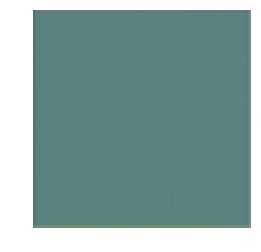

11 0.94899905 0.16280968
12 0.8968905 0.18217999
13 0.8423551 0.2054309
14 0.7987542 0.22622445
15 0.7520938 0.25153914
16 0.7126602 0.27532607
17 0.67361814 0.30132127
18 0.6425368 0.32388788
19 0.6091332 0.35081145
20 0.57981616 0.3765673
not training generator


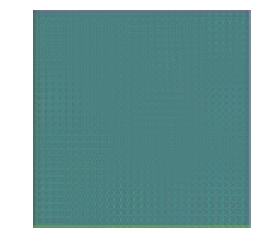

21 0.5554452 0.39950004
22 0.5270062 0.42883474
23 0.506079 0.45177203
24 0.4853478 0.47625542
25 0.46348462 0.5040133
26 0.44669342 0.5265003
27 0.42867494 0.5523003
28 0.41308385 0.5758946
29 0.41337067 0.5754417
30 0.4128335 0.57622826
not training discriminator


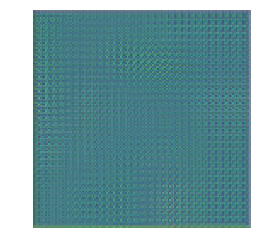

31 0.41258246 0.5766396
32 0.41338482 0.57540476
33 0.41097993 0.57913435
34 0.4129849 0.57598174
35 0.4156488 0.57188636
36 0.41377312 0.5748478
37 0.41151673 0.57829714
38 0.4131906 0.5757053
39 0.41319543 0.57575554
40 0.41363758 0.57495296
not training discriminator


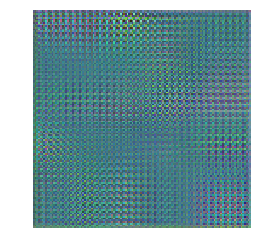

41 0.41500244 0.572862
42 0.41482154 0.5732115
43 0.4148918 0.5730069
44 0.41471156 0.5733961
45 0.4158593 0.5717179
46 0.416121 0.5712117
47 0.41685408 0.5700251
48 0.41480342 0.57316124
49 0.4162423 0.57103366
50 0.4168767 0.5699879
not training discriminator


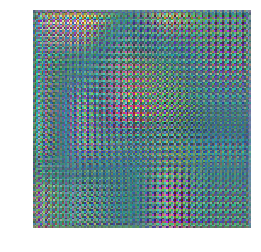

51 0.41447854 0.57374746
52 0.41691083 0.5699492
53 0.4182225 0.5679473
54 0.4191907 0.5664867
55 0.4179644 0.5684428
56 0.41978425 0.5655302
57 0.4036127 0.5909039
58 0.4045064 0.58953273
59 0.40587258 0.5873617
60 0.40599704 0.5870897
not training discriminator


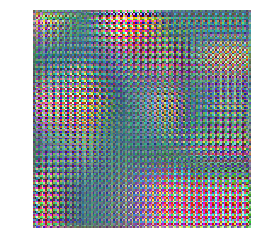

61 0.40603295 0.5870636
62 0.40535277 0.5880972
63 0.40770015 0.5844014
64 0.40764865 0.584332
65 0.4065826 0.5861935
66 0.40616137 0.5868577
67 0.40950602 0.58143646
68 0.4100069 0.5807394
69 0.41181135 0.57801664
70 0.41179585 0.57791936
not training discriminator


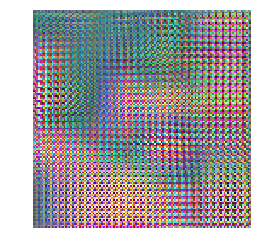

71 0.41364956 0.57510686
72 0.41294885 0.5760142
73 0.4140331 0.57436496
74 0.41719937 0.56964046
75 0.41910595 0.5666139
76 0.41948968 0.5659882
77 0.40165073 0.5943208
78 0.40525222 0.58827835
79 0.40796918 0.58413064
80 0.4088393 0.58280796
not training discriminator


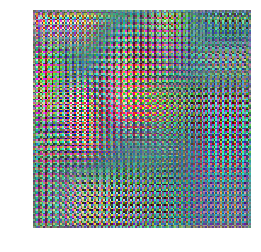

81 0.4096767 0.58124006
82 0.41103387 0.5793896
83 0.41088074 0.5794114
84 0.41467458 0.5733913
85 0.4158128 0.5717739
86 0.4173625 0.5692744
87 0.42274857 0.5611234
88 0.40475303 0.58913934
89 0.4092636 0.5820729
90 0.40972033 0.5813714
not training discriminator


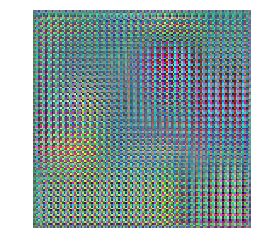

91 0.4124729 0.5769286
92 0.4152038 0.5733595
93 0.46549454 0.5707165
94 0.5907444 0.36680713
95 0.5443503 0.41066128
96 0.51213324 0.44502974
97 0.4836883 0.47900486
98 0.46418747 0.50319004
99 0.4387745 0.5378196


In [7]:
for i in range(100):
    train_d = True
    train_g = True
    keep_prob_train = 0.5
        
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
    batch = [b for b in next_batch(num=batch_size)]   

    d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], 
                                                feed_dict={X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    d_fake_ls_init = d_fake_ls
    
    d_real_ls = np.mean(d_real_ls)
    d_fake_ls = np.mean(d_fake_ls)
    g_ls = g_ls
    d_ls = d_ls
        
    if g_ls * 1.35 < d_ls:
        train_g = False
        pass
    if d_ls * 1.35 < g_ls:
        train_d = False
        pass
    
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, X_in: batch, keep_prob: keep_prob_train, is_training:True})
                
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
    print (i, d_ls, g_ls)
    if not i % 10:
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        imgs = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
        save_imgs(imgs, i)

Animation.save using <class 'matplotlib.animation.ImageMagickFileWriter'>
MovieWriter.run: running command: C:\Program Files\ImageMagick-7.0.7-Q16\convert.exe -delay 20.0 -loop 0 _tmp*.png ./output/single.gif
100


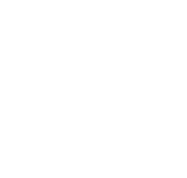

In [18]:
_ = gif.build_gif(allimgs, saveto=output_dir + "/" + 'single.gif', show_gif=False)
print(len(allimgs))